In [1]:
import pandas as pd
from fancyimpute import IterativeImputer
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, ParameterGrid, ParameterSampler
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.feature_selection import RFE, RFECV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

train = pd.read_csv('https://raw.githubusercontent.com/casperbh96/house-price-prediction/master/Experimental/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/casperbh96/house-price-prediction/master/Experimental/data/test.csv')

def fill_ii(df):
    df_filled_ii = pd.DataFrame(IterativeImputer().fit_transform(df.values))
    df_filled_ii.columns = df.columns
    df_filled_ii.index = df.index

    return df_filled_ii

def data_engineering(train, test):
    train = train.drop(train.index[0])
    
    cc_data = pd.concat([train, test], sort=True)
    cc_data = cc_data.drop(['Id', 'SalePrice','Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)
    
    train["SalePrice"] = np.log1p(train["SalePrice"])
    y = train['SalePrice']
    
    cc_data = pd.get_dummies(cc_data, prefix_sep='_')
    
    cc_data = fill_ii(cc_data)
    
    X_train = cc_data[:train.shape[0]]
    X_test = cc_data[train.shape[0]:]
    
    return X_train,X_test,y

X,X_test,y = data_engineering(train,test)

Using TensorFlow backend.


In [2]:
class NestedCV():
    '''A general class to handle nested cross-validation for any estimator that
    implements the scikit-learn estimator interface.

    Parameters
    ----------
    model : estimator
        The estimator implements scikit-learn estimator interface.

    params_grid : dict
        The dict contains hyperparameters for model.

    outer_kfolds : int
        Number of outer K-partitions in KFold

    inner_kfolds : int
        Number of inner K-partitions in KFold

    cv_options: dict, default = {}
        Nested CV Options, check docs for details.

        metric : callable from sklearn.metrics, default = mean_squared_error
            A scoring metric used to score each model

        metric_score_indicator_lower : boolean, default = True
            Choose whether lowe score is better for the metric calculation or hight score is better, `True` means lower score is better.

        sqrt_of_score : boolean, default = False
            Whether or not if the square root should be taken of score

        randomized_search : boolean, default = True
            Whether to use gridsearch or randomizedsearch from sklearn

        randomized_search_iter : int, default = 10
            Number of iterations for randomized search

        recursive_feature_elimination : boolean, default = False
            Whether to do feature elimination
    '''

    def __init__(self, model, params_grid, outer_kfolds, inner_kfolds, cv_options={}):
        self.model = model
        self.params_grid = params_grid
        self.outer_kfolds = outer_kfolds
        self.inner_kfolds = inner_kfolds
        self.metric = cv_options.get('metric', mean_squared_error)
        self.metric_score_indicator_lower = cv_options.get(
            'metric_score_indicator_lower', True)
        self.sqrt_of_score = cv_options.get('sqrt_of_score', False)
        self.randomized_search = cv_options.get('randomized_search', True)
        self.randomized_search_iter = cv_options.get(
            'randomized_search_iter', 10)
        self.recursive_feature_elimination = cv_options.get(
            'recursive_feature_elimination', False)
        self.outer_scores = []
        self.best_params = {}
        self.best_inner_score_list = []
        self.variance = []

    # to check if use sqrt_of_score and handle the different cases
    def _transform_score_format(self, scoreValue):
        if self.sqrt_of_score:
            return np.sqrt(scoreValue)
        return scoreValue

    # to convert array of dict to dict with array values, so it can be used as params for parameter tuning
    def _score_to_best_params(self, best_inner_params_list):
        params_dict = {}
        for best_inner_params in best_inner_params_list:
            for key, value in best_inner_params.items():
                if key in params_dict:
                    if value not in params_dict[key]:
                        params_dict[key].append(value)
                else:
                    params_dict[key] = [value]
        return params_dict

    # a method to handle  recursive feature elimination
    def _fit_recursive_feature_elimination(self, best_inner_params, X_train_outer, y_train_outer, X_test_outer):
        print('\nRunning recursive feature elimination for outer loop... (SLOW)')
        # K-fold (inner_kfolds) recursive feature elimination
        rfe = RFECV(estimator=self.model, min_features_to_select=20,
                    scoring='neg_mean_squared_error', cv=self.inner_kfolds, n_jobs=-1)
        rfe.fit(X_train_outer, y_train_outer)

        # Assign selected features to data
        print('Best number of features was: {0}'.format(rfe.n_features_))
        X_train_outer_rfe = rfe.transform(X_train_outer)
        X_test_outer_rfe = rfe.transform(X_test_outer)

        # Train model with best inner parameters on the outer split
        self.model.set_params(**best_inner_params)
        self.model.fit(X_train_outer_rfe, y_train_outer)
        return self.model.predict(X_test_outer_rfe)

    def fit(self, X, y):
        '''A method to fit nested cross-validation 
        Parameters
        ----------
        X : pandas dataframe (rows, columns)
            Training dataframe, where rows is total number of observations and columns
            is total number of features
    
        y : pandas dataframe
            Output dataframe, also called output variable. y is what you want to predict.
    
        Returns
        -------
        It will not return directly the values, but it's accessable from the class object it self.
        You should be able to access:
        
        variance
            Model variance by numpy.var()
            
        outer_scores 
            Outer score List.
            
        best_inner_score_list 
            Best inner scores for each outer loop
            
        best_params 
            All best params from each inner loop cumulated in a dict
            
        best_inner_params_list 
            Best inner params for each outer loop as an array of dictionaries
        '''
    
        print('\n{0} <-- Running this model now'.format(type(self.model).__name__))
        outer_cv = KFold(n_splits=self.outer_kfolds, shuffle=True)
        inner_cv = KFold(n_splits=self.inner_kfolds, shuffle=True)
        model = self.model
    
        outer_scores = []
        variance = []
        best_inner_params_list = []  # Change both to by one thing out of key-value pair
        best_inner_score_list = []
    
        # Split X and y into K-partitions to Outer CV
        for (i, (train_index, test_index)) in enumerate(outer_cv.split(X, y)):
            print('\n{0}/{1} <-- Current outer fold'.format(i+1, self.outer_kfolds))
            X_train_outer, X_test_outer = X.iloc[train_index], X.iloc[test_index]
            y_train_outer, y_test_outer = y.iloc[train_index], y.iloc[test_index]
            best_inner_params = {}
            best_inner_score = None
    
            # Split X_train_outer and y_train_outer into K-partitions to be inner CV
            for (j, (train_index_inner, test_index_inner)) in enumerate(inner_cv.split(X_train_outer, y_train_outer)):
                print('\n\t{0}/{1} <-- Current inner fold'.format(j+1, self.inner_kfolds))
                X_train_inner, X_test_inner = X_train_outer.iloc[
                    train_index_inner], X_train_outer.iloc[test_index_inner]
                y_train_inner, y_test_inner = y_train_outer.iloc[
                    train_index_inner], y_train_outer.iloc[test_index_inner]
    
                # Run either RandomizedSearch or GridSearch for input parameters
                for param_dict in ParameterSampler(param_distributions=self.params_grid, 
                                                   n_iter=self.randomized_search_iter) if (self.randomized_search) else (
                                                           ParameterGrid(param_grid=self.params_grid)):
                    # Set parameters, train model on inner split, predict results.
                    if(type(self.model).__name__ == 'KerasRegressor'):
                        with tf.device('/gpu:0'):
                          model.set_params(**param_dict)
                          model.fit(X_train_inner, y_train_inner)
                    else:
                      model.set_params(**param_dict)
                      model.fit(X_train_inner, y_train_inner)
                    
                    
                    inner_pred = model.predict(X_test_inner)
                    inner_grid_score = self.metric(y_test_inner, inner_pred)
                    current_inner_score_value = best_inner_score
                    # Find best score and corresponding best grid
                    if(best_inner_score is not None):
                        if(self.metric_score_indicator_lower and best_inner_score > inner_grid_score):
                            best_inner_score = self._transform_score_format(inner_grid_score)
                            
                        elif (not self.metric_score_indicator_lower and best_inner_score < inner_grid_score):
                            best_inner_score = self._transform_score_format(inner_grid_score)
                    else:
                        best_inner_score = self._transform_score_format(inner_grid_score)
                        current_inner_score_value = best_inner_score+1  # first time random thing
                        
                    # Update best_inner_grid once rather than calling it under each if statement
                    if(current_inner_score_value is not None and current_inner_score_value != best_inner_score):
                        best_inner_params = param_dict
    
            best_inner_params_list.append(best_inner_params)
            best_inner_score_list.append(best_inner_score)
    
            if self.recursive_feature_elimination:
                pred = self._fit_recursive_feature_elimination(
                    best_inner_params, X_train_outer, y_train_outer, X_test_outer)
            else:
                # Train model with best inner parameters on the outer split
                model.set_params(**best_inner_params)
                model.fit(X_train_outer, y_train_outer)
                pred = model.predict(X_test_outer)
    
            outer_scores.append(self._transform_score_format(
                self.metric(y_test_outer, pred)))
    
            # Append variance
            variance.append(np.var(pred, ddof=1))
    
            print('\nResults for outer fold:\nBest inner parameters was: {0}'.format(
                best_inner_params_list[i]))
            print('Outer score: {0}'.format(outer_scores[i]))
            print('Inner score: {0}'.format(best_inner_score_list[i]))
    
        self.variance = variance
        self.outer_scores = outer_scores
        self.best_inner_score_list = best_inner_score_list
        self.best_params = self._score_to_best_params(best_inner_params_list)
        self.best_inner_params_list = best_inner_params_list

    # Method to show score vs variance chart. You can run it only after fitting the model.
    def score_vs_variance_plot(self):
        # Plot score vs variance
        plt.figure()
        plt.subplot(211)

        variance_plot, = plt.plot(self.variance, color='b')
        score_plot, = plt.plot(self.outer_scores, color='r')

        plt.legend([variance_plot, score_plot],
                   ["Variance", "Score"],
                   bbox_to_anchor=(0, .4, .5, 0))

        plt.title("{0}: Score VS Variance".format(type(self.model).__name__),
                  x=.5, y=1.1, fontsize="15")


In [3]:
#NestedCV parameters
NUM_TRIALS = 50
outerFolds = 5
innerFolds = 5

models_to_run = [xgb.XGBRegressor()]
models_param_grid = [
                    { # 3rd param grid, corresponding to XGBRegressor
                            'learning_rate': [0.05],
                            'colsample_bytree': np.linspace(0.3, 0.5),
                            'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
                            'reg_alpha' : (1,1.2),
                            'reg_lambda' : (1,1.2,1.4)
                    }
                    ]
XGB_scores = []

In [4]:
for trial in range(NUM_TRIALS):
    print('Running {0} / {1}'.format(trial,NUM_TRIALS))
    for i,model in enumerate(models_to_run):
        nested_CV_search = NestedCV(model=model, params_grid=models_param_grid[i], outer_kfolds=outerFolds, inner_kfolds=innerFolds, 
                          cv_options={'sqrt_of_score':True, 'randomized_search_iter':30})
        nested_CV_search.fit(X=X,y=y)
        model_param_grid = nested_CV_search.best_params
        print('\nCumulated best parameter grids was:\n{0}'.format(model_param_grid))
        
        gscv = GridSearchCV(estimator=model,param_grid=model_param_grid,scoring='neg_mean_squared_error',cv=5, n_jobs=-1)
        gscv.fit(X,y)
        
        print('\nFitting with optimal parameters:\n{0}'.format(gscv.best_params_))
        gscv.predict(X_test)
        score = np.sqrt(-gscv.best_score_)
        
        if(type(model).__name__ == 'KerasRegressor'):
            NN_scores.append(score)
        elif(type(model).__name__ == 'RandomForestRegressor'):
            RF_scores.append(score)
        elif(type(model).__name__ == 'XGBRegressor'):
            XGB_scores.append(score)
        
        print('\nFinal score for {0} was {1}'.format(type(model).__name__,score))

Running 0 / 50

XGBRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1, 'n_estimators': 600, 'learning_rate': 0.05, 'colsample_bytree': 0.34489795918367344}
Outer score: 0.13286444683200466
Inner score: 0.10566130720372194

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 700, 'learning_rate': 0.05, 'colsample_bytree': 0.32857142857142857}
Outer score: 0.12688739734824372
Inner score: 0.1307218780480813

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/


	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1, 'n_estimators': 500, 'learning_rate': 0.05, 'colsample_bytree': 0.41428571428571426}
Outer score: 0.12613150274882642
Inner score: 0.13752861333150634

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'learning_rate': 0.05, 'colsample_bytree': 0.3857142857142857}
Outer score: 0.11374699662520937
Inner score: 0.14577769749415487

4/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambd


	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1.2, 'n_estimators': 400, 'learning_rate': 0.05, 'colsample_bytree': 0.463265306122449}
Outer score: 0.13006518207917417
Inner score: 0.11484238794295215

4/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1, 'n_estimators': 300, 'learning_rate': 0.05, 'colsample_bytree': 0.41836734693877553}
Outer score: 0.12217510278228344
Inner score: 0.12905907234413205

5/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lamb


	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1.2, 'n_estimators': 700, 'learning_rate': 0.05, 'colsample_bytree': 0.3816326530612245}
Outer score: 0.14152650805605194
Inner score: 0.12973591801858628

5/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 400, 'learning_rate': 0.05, 'colsample_bytree': 0.38979591836734695}
Outer score: 0.12325338489541687
Inner score: 0.14322948611910752

Cumulated best parameter grids was:
{'reg_lambda': [1, 1.2, 1.4], 'reg_alpha': [1.2, 1], 'n_estimators': [1000, 200, 500, 700, 400], 'learning_rate': [0.05], 'colsample_bytree': [0.4673469387755102, 0.4306122448979592, 0.3, 0.3816326530612245, 0.38979591836734695]}

Fitting with optimal parameters:
{'colsample_bytree':


Fitting with optimal parameters:
{'colsample_bytree': 0.32040816326530613, 'learning_rate': 0.05, 'n_estimators': 900, 'reg_alpha': 1, 'reg_lambda': 1.2}

Final score for XGBRegressor was 0.12351150548219389
Running 13 / 50

XGBRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1.2, 'n_estimators': 700, 'learning_rate': 0.05, 'colsample_bytree': 0.336734693877551}
Outer score: 0.12414459511264961
Inner score: 0.11103650459114514

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1, 'n_estimators': 300, 'learning_rate': 0.05, 'colsample_bytree':


Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1.2, 'n_estimators': 300, 'learning_rate': 0.05, 'colsample_bytree': 0.3163265306122449}
Outer score: 0.10396208230510909
Inner score: 0.13282131919662313

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1.2, 'n_estimators': 300, 'learning_rate': 0.05, 'colsample_bytree': 0.336734693877551}
Outer score: 0.15350401426860863
Inner score: 0.11563047670083516

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1.2, 'n_estimators': 900, 'learning_rate': 0.05, 'colsample_bytree': 0.37755102040816324}
Oute


	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 0.41836734693877553}
Outer score: 0.1392083568048139
Inner score: 0.11401400316042196

4/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1, 'n_estimators': 500, 'learning_rate': 0.05, 'colsample_bytree': 0.373469387755102}
Outer score: 0.1058556539537943
Inner score: 0.167603474319795

5/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda':


	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1, 'n_estimators': 1000, 'learning_rate': 0.05, 'colsample_bytree': 0.4714285714285714}
Outer score: 0.12064706744414287
Inner score: 0.14254924111175085

5/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'learning_rate': 0.05, 'colsample_bytree': 0.3857142857142857}
Outer score: 0.13209033100395293
Inner score: 0.12503876022859728

Cumulated best parameter grids was:
{'reg_lambda': [1.2, 1.4, 1], 'reg_alpha': [1, 1.2], 'n_estimators': [1000, 600, 300], 'learning_rate': [0.05], 'colsample_bytree': [0.4306122448979592, 0.4959183673469388, 0.463265306122449, 0.4714285714285714, 0.3857142857142857]}

Fitting with optimal parameters:
{'colsample_bytree'


Fitting with optimal parameters:
{'colsample_bytree': 0.3, 'learning_rate': 0.05, 'n_estimators': 1000, 'reg_alpha': 1.2, 'reg_lambda': 1}

Final score for XGBRegressor was 0.12310873473818695
Running 26 / 50

XGBRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 300, 'learning_rate': 0.05, 'colsample_bytree': 0.42244897959183675}
Outer score: 0.1341460012878373
Inner score: 0.1317404875564157

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 500, 'learning_rate': 0.05, 'colsample_bytree': 0.414285714285


Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1, 'n_estimators': 500, 'learning_rate': 0.05, 'colsample_bytree': 0.42244897959183675}
Outer score: 0.12168866918459217
Inner score: 0.1324531845872798

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 0.3857142857142857}
Outer score: 0.10195825234331075
Inner score: 0.13739449548687196

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1.2, 'n_estimators': 500, 'learning_rate': 0.05, 'colsample_bytree': 0.32857142857142857}
Out


Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 0.39387755102040817}
Outer score: 0.11827100638486342
Inner score: 0.12080602916364863

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 300, 'learning_rate': 0.05, 'colsample_bytree': 0.42653061224489797}
Outer score: 0.12129259232086312
Inner score: 0.15461301598050867

4/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1.2, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 0.41428571428571426}


Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 100, 'learning_rate': 0.05, 'colsample_bytree': 0.41428571428571426}
Outer score: 0.16806722349157086
Inner score: 0.1713263712537916

4/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1.2, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 0.32857142857142857}
Outer score: 0.13756786576574642
Inner score: 0.13521797042629904

5/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1.2, 'n_estimators': 700, 'learning_rate': 0.05, 'colsample_bytree': 0.3081632653061224}


Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 1000, 'learning_rate': 0.05, 'colsample_bytree': 0.3979591836734694}
Outer score: 0.14787082805724916
Inner score: 0.1288636137327747

5/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 100, 'learning_rate': 0.05, 'colsample_bytree': 0.3408163265306122}
Outer score: 0.1601892607642469
Inner score: 0.1595141107796773

Cumulated best parameter grids was:
{'reg_lambda': [1.4, 1.2, 1], 'reg_alpha': [1.2, 1], 'n_estimators': [500, 700, 100, 1000], 'learning_rate': [0.05], 'colsample_bytree': [0.3693877551020408, 0.4020408163265306, 0.373469387755102, 0.3979591836734694, 0.3408163265306122]}

Fitting with optimal parameters:
{'colsample_bytree': 0.3979591836734694, 'le


Fitting with optimal parameters:
{'colsample_bytree': 0.3081632653061224, 'learning_rate': 0.05, 'n_estimators': 900, 'reg_alpha': 1.2, 'reg_lambda': 1.2}

Final score for XGBRegressor was 0.12288280066776344
Running 42 / 50

XGBRegressor <-- Running this model now

1/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1.2, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 0.42244897959183675}
Outer score: 0.14055016490102143
Inner score: 0.1438686237797463

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1.2, 'n_estimators': 1000, 'learning_rate': 0.05, 'colsample_b


Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1, 'n_estimators': 100, 'learning_rate': 0.05, 'colsample_bytree': 0.3163265306122449}
Outer score: 0.1935374727302888
Inner score: 0.1683005026158897

2/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 500, 'learning_rate': 0.05, 'colsample_bytree': 0.39387755102040817}
Outer score: 0.15382892642539822
Inner score: 0.11771601760590834

3/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 400, 'learning_rate': 0.05, 'colsample_bytree': 0.4959183673469388}
Out


	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.2, 'reg_alpha': 1.2, 'n_estimators': 300, 'learning_rate': 0.05, 'colsample_bytree': 0.35306122448979593}
Outer score: 0.1370877466279439
Inner score: 0.1256312626244896

4/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_lambda': 1.4, 'reg_alpha': 1, 'n_estimators': 1000, 'learning_rate': 0.05, 'colsample_bytree': 0.36122448979591837}
Outer score: 0.14928340344624125
Inner score: 0.10162444375842851

5/5 <-- Current outer fold

	1/5 <-- Current inner fold

	2/5 <-- Current inner fold

	3/5 <-- Current inner fold

	4/5 <-- Current inner fold

	5/5 <-- Current inner fold

Results for outer fold:
Best inner parameters was: {'reg_l

Text(0.5, 1.1, 'Test scores as RMSLE with hyperparameter optimization')

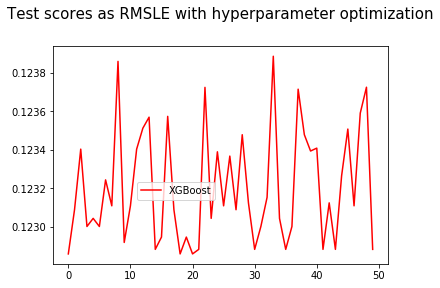

In [5]:
plt.figure()

xgb, = plt.plot(XGB_scores, color='r')

plt.legend([xgb],
           ["XGBoost"],
           bbox_to_anchor=(0, .4, .5, 0))

plt.title('Test scores as RMSLE with hyperparameter optimization',
          x=.5, y=1.1, fontsize="15")

In [6]:
print(XGB_scores)
print('XG boost generalization score: {0}'.format(np.mean(XGB_scores)))

[0.12285918765311826, 0.12308848336013453, 0.12340290103805583, 0.12300148616038144, 0.12304363383441481, 0.12300148616038144, 0.12324333627358379, 0.12310873473818695, 0.12385820595327121, 0.12291868397922509, 0.12310873473818695, 0.12340290103805583, 0.12351150548219389, 0.1235687127336375, 0.12288280066776344, 0.12294658911851963, 0.12357289666912612, 0.12308848336013453, 0.12285918765311826, 0.12294658911851963, 0.12285918765311826, 0.12288280066776344, 0.1237233352051254, 0.12304363383441481, 0.12338903397723817, 0.12310873473818695, 0.12336676784684086, 0.12308848336013453, 0.12347768972069903, 0.12312407337404939, 0.12288280066776344, 0.12300148616038144, 0.12315287091405902, 0.12388486003239549, 0.12304363383441481, 0.12288280066776344, 0.12300148616038144, 0.12371391509537898, 0.12347768972069903, 0.12339314622044432, 0.1234080799983327, 0.12288280066776344, 0.12312407337404939, 0.12288280066776344, 0.12326497799736569, 0.12350700176547169, 0.12310873473818695, 0.1235896819633